   Running Decision Tree Model
   File: Suvarnabhumi_NotScaled_Onehot_Minmax_ALL_Arrival
Target Column Identified: 'Passenger_Arrival_Filled'
Training Samples: 734
Testing Samples: 184

Starting Grid Search (this may take a while)...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
Grid Search Complete.
Best Parameters: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 20}
Rank 1 Params: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 20}
Rank 2 Params: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 20}
Rank 3 Params: {'criterion': 'squared_error', 'max_depth': 30, 'min_samples_leaf': 8, 'min_samples_split': 20}


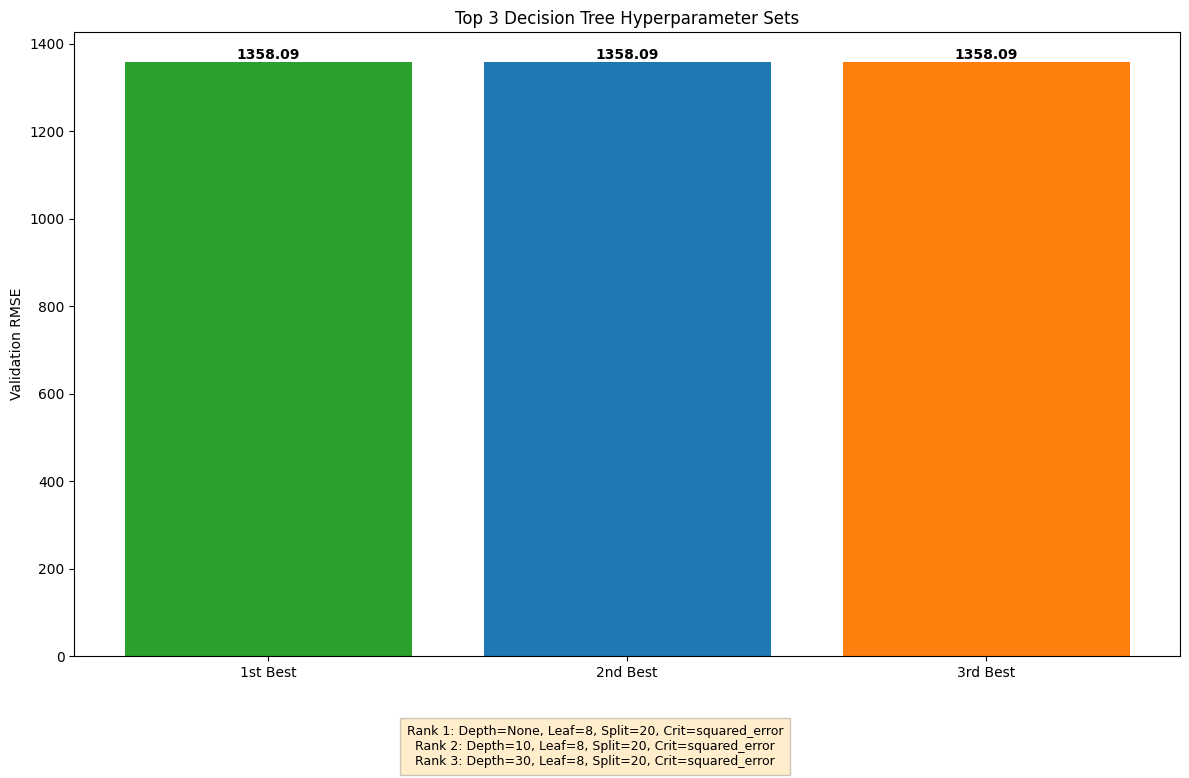


--- Final Test Set Evaluation ---
RMSE: 888.2726
MAE: 721.3222
MAPE: 0.0536


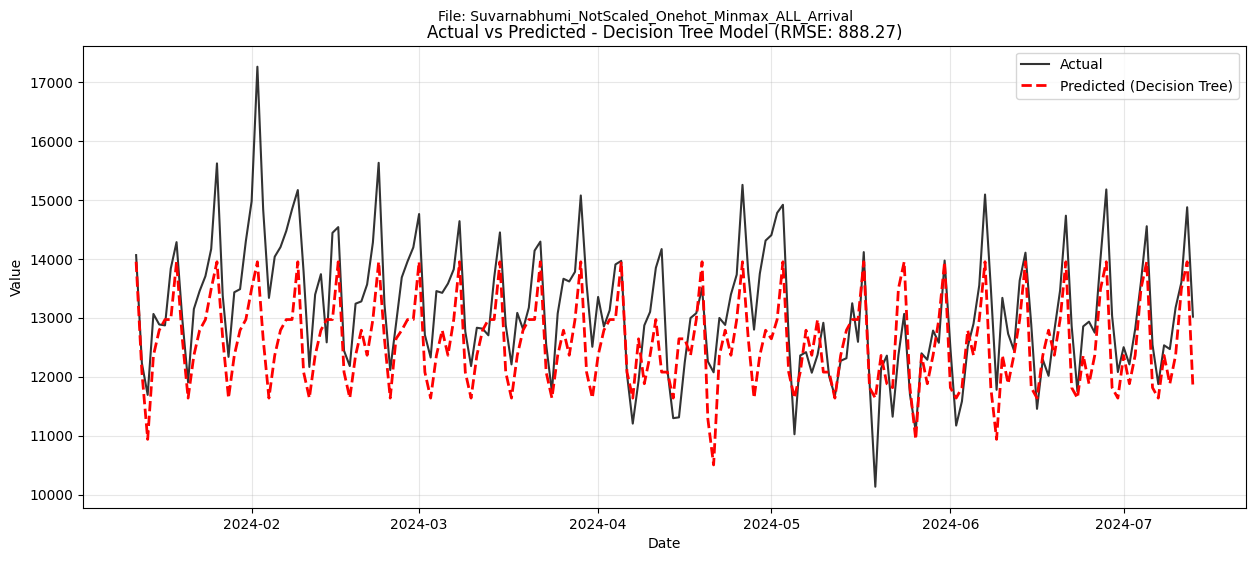

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings

# ปิด Warning เพื่อความสะอาดของ Output
warnings.filterwarnings('ignore')

def run_decision_tree_model(file_path):
    print(f"========================================")
    print(f"   Running Decision Tree Model")
    print(f"   File: {file_path[5:-4]}")
    print(f"========================================")

    # ---------------------------------------------------------
    # 1. Load Data & Preprocessing
    # ---------------------------------------------------------
    df = pd.read_csv(file_path)

    # แปลง Date เป็น datetime และเรียงลำดับ
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # ระบุ Target Column (คอลัมน์ที่ 2 ถัดจาก Date เสมอ)
    target_col = df.columns[1]
    print(f"Target Column Identified: '{target_col}'")

    # แบ่ง Features (X) และ Target (y)
    X = df.drop(columns=['Date', target_col])
    y = df[target_col]

    # ---------------------------------------------------------
    # 2. Train-Test Split (80:20 แบบ Time Series)
    # ---------------------------------------------------------
    train_size = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

    # เก็บวันที่ของ Test set ไว้สำหรับ Plot กราฟ
    test_dates = df['Date'].iloc[train_size:]

    print(f"Training Samples: {len(X_train)}")
    print(f"Testing Samples: {len(X_test)}")

    # ---------------------------------------------------------
    # 3. Grid Search Parameter Tuning
    # ---------------------------------------------------------
    print("\nStarting Grid Search (this may take a while)...")

    # กำหนด Cross Validation แบบ Time Series (5 splits)
    tscv = TimeSeriesSplit(n_splits=5)


    param_grid = {
        'criterion': ['squared_error', 'absolute_error', 'poisson'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
    }

    # กำหนด Seed (random_state=42) เพื่อผลลัพธ์ที่คงที่
    dt = DecisionTreeRegressor(random_state=42)

    grid_search = GridSearchCV(
        estimator=dt,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_root_mean_squared_error', # ใช้ RMSE เป็นเกณฑ์ตัดสิน (ค่าจะเป็นลบ ยิ่งใกล้ 0 ยิ่งดี)
        n_jobs=-1, # ใช้ทุก CPU Core ช่วยประมวลผล
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print("Grid Search Complete.")
    print(f"Best Parameters: {grid_search.best_params_}")

    # ---------------------------------------------------------
    # 4. Analyze Top 3 Parameters (Bar Chart)
    # ---------------------------------------------------------
    results = pd.DataFrame(grid_search.cv_results_)
    top_3 = results.sort_values('rank_test_score').head(3)

    # แปลง Score กลับเป็นค่าบวก (RMSE)
    top_3_rmse = -top_3['mean_test_score']

    # สร้างกราฟแท่งเปรียบเทียบ Top 3
    plt.figure(figsize=(12, 7))
    bars = plt.bar(range(3), top_3_rmse, color=['#2ca02c', '#1f77b4', '#ff7f0e'])
    plt.xticks(range(3), ['1st Best', '2nd Best', '3rd Best'])
    plt.ylabel('Validation RMSE')
    plt.title('Top 3 Decision Tree Hyperparameter Sets')
    # ใส่ค่า RMSE บนแท่งกราฟ
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom', fontweight='bold')

    # สร้างคำอธิบายพารามิเตอร์ (Legend Text) ด้านล่างกราฟ
    param_texts = []
    for i, (idx, row) in enumerate(top_3.iterrows()):
        p = row['params']
        # จัดรูปแบบข้อความให้สั้นลง
        # The original code had 'Feat={p['max_features']}' which caused a KeyError as 'max_features' is not in param_grid.
        p_str = f"Rank {i+1}: Depth={p['max_depth']}, Leaf={p['min_samples_leaf']}, Split={p['min_samples_split']}, Crit={p['criterion']}"
        param_texts.append(p_str)
        print(f"Rank {i+1} Params: {p}") # Print to console as well

    # แสดงรายละเอียดพารามิเตอร์บนกราฟ
    plt.figtext(0.5, -0.1, "\n".join(param_texts), ha="center", fontsize=9, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    # 5. Final Prediction on Test Set
    # ---------------------------------------------------------
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # ---------------------------------------------------------
    # 6. Evaluation Metrics
    # ---------------------------------------------------------
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"\n--- Final Test Set Evaluation ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}")

    # ---------------------------------------------------------
    # 7. Plot Actual vs Predicted
    # ---------------------------------------------------------
    plt.figure(figsize=(15, 6))
    plt.plot(test_dates, y_test, label='Actual', color='black', alpha=0.8)
    plt.plot(test_dates, y_pred, label='Predicted (Decision Tree)', color='red', linestyle='--', linewidth=2)
    plt.title(f'Actual vs Predicted - Decision Tree Model (RMSE: {rmse:.2f})')
    plt.suptitle(f'File: {target_file[5:-4]}', y=0.94, fontsize=10)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    final_results = pd.DataFrame({
        'criterion': [best_model.criterion],
        'max_depth': [best_model.max_depth],
        'min_samples_leaf': [best_model.min_samples_leaf],
        'min_samples_split': [best_model.min_samples_split],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape]
    })

    #save resluts===========================================
    final_results.to_csv(f'DT_Results{target_file[5:-4]}.csv', index=False)

# ========================================================
# ส่วนกำหนดค่าเริ่มต้น (Configuration)
# ========================================================
if __name__ == "__main__":
    target_file = r'data\Suvarnabhumi_NotScaled_Onehot_Minmax_ALL_Arrival.csv'

    # เรียกใช้งานฟังก์ชัน
    run_decision_tree_model(target_file)